<a href="https://colab.research.google.com/github/sethkipsangmutuba/Statistical-Data-Science/blob/main/Note_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

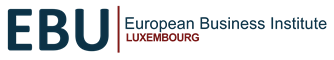

# Longitudinal Data Analysis  
**Seth Kipsang**  

---

## **Lecture Outline**

---

### **1. Foundations of Longitudinal Data Analysis**

- Motivation for longitudinal studies  
- Distinguishing longitudinal from cross-sectional frameworks  
- Sources of intra-individual correlation  
- Likelihood-based approaches for repeated measures  
- Maximum Likelihood and Restricted Maximum Likelihood  
- Deviance, model comparison, and goodness-of-fit diagnostics  

---

### **2. Generalized Estimating Equations (GEE)**

- Relationship between Linear Models, Generalized Linear Models, and GEE  
- Working correlation structures and their practical implications  
- Population-averaged inference versus subject-specific inference  
- Robust (sandwich) variance estimators  
- Model selection and convergence considerations  

---

### **3. Linear Mixed-Effects Models**

- Hierarchical structure and random effects formulation  
- Subject-specific trajectories and covariance modeling  
- Estimation via REML and ML  
- Interpretation of fixed and random effects  
- Model diagnostics, residual structure, and goodness-of-fit  
- Comparison of Mixed Models and GEE: conceptual and inferential contrasts  

---


#PART A : Foundations of Longitudinal Data Analysis

## (a) Introduction

Longitudinal data analysis focuses on statistical methods for repeated measurements on the same individuals over time.

It is central to epidemiology, clinical research, and therapeutic evaluation.

Common applications include modelling growth and aging, and assessing how risk factors influence outcomes as they change over time.


## (b) Benefits of Longitudinal Studies

**Capture of incident events:**  Prospective follow-up allows recording of new disease onset and linking timing of events to recent or cumulative exposures.

**Prospective measurement of exposure:**  Exposure status is updated across visits, reducing recall bias and improving measurement accuracy.

**Assessment of individual change:**  Repeated measures enable tracking of within-person change in outcomes or exposures, revealing individual trajectories.

**Separation of time-related effects:**  Longitudinal designs support disentangling age, period, and cohort effects when studying temporal patterns.


## (c) Challenges of Longitudinal Analysis

**Participant follow-up:**  Dropouts or incomplete follow-up can introduce bias if participants who remain differ systematically from those who leave, potentially compromising representativeness.

**Analysis of correlated data:**  Repeated measures are inherently correlated. Ignoring intra-subject correlation can lead to invalid statistical inferences, including biased tests and confidence intervals.

**Time-varying covariates and feedback:**  Changes in exposures may be influenced by prior outcomes, creating reciprocal relationships. Disentangling the causal effect of exposure from the effect of outcomes on exposure requires careful modeling.


## (d) Basics of Longitudinal Modeling

**Key Concept:**  
Longitudinal data involve intra-individual correlation, which arises because repeated measurements on the same subject are not independent. Proper modeling must account for three sources of variability:

- **Between-subject variability ($b_i$)** – differences in average response across subjects; some subjects are inherently high or low.  
- **Time-varying processes ($\tilde{W}_i(T_{ij})$)** – changes in measurements over time due to dynamic processes within subjects.  
- **Within-subject measurement error ($\epsilon_{ij}$)** – variability from sub-sampling or measurement noise.  

**Multivariate Linear Model:**

$$
Y_{ij} = X_{ij}^T \beta + b_i + \tilde{W}_i(T_{ij}) + \epsilon_{ij}
$$

Where:  
- $\beta$ → fixed effects representing average response.  
- $b_i$ → random effect for subject $i$, capturing between-subject variability.  
- $\tilde{W}_i(T_{ij})$ → time-varying process for subject $i$ at time $j$.  
- $\epsilon_{ij}$ → measurement error, assumed independent across time points.  

**Assumptions:**  
Random components $b_i$, $\tilde{W}_i(T_{ij})$, and $\epsilon_{ij}$ are usually normally distributed with specified variances/covariance structures. Conditional independence ensures unbiased estimation of $\beta$.  

**Practical Implication:**  
Mixed-effects models are widely used to address intra-individual correlation by modeling between-subject random effects, while capturing systematic and residual variation efficiently. In practice, often one main source of systematic variability dominates and guides model specification.


## (e) Example: BodyWeight Study in Rats

### Study Overview
- Longitudinal measurements of 16 rats over 64 days.  
- Rats divided into three diet groups.  
- Weights recorded on day 1, every 7 days, with an additional measurement on day 44.  
- Total observations: 176.  

### Dataset Columns
- **weight (grams)** – body weight of the rat  
- **Time (day)** – measurement day  
- **Rat** – rat identifier  
- **Diet** – diet group (1–3)  

### Scientific Motivation
- Track individual growth trajectories.  
- Assess diet effects on weight gain.  
- Analyze within-subject changes and between-subject differences.  

### Significance
- Illustrates repeated-measures design.  
- Supports modeling growth trends and diet impacts using longitudinal methods.  


###Load Dataset

In [323]:
import warnings
warnings.filterwarnings('ignore')


In [324]:
import statsmodels.api as sm

bw = sm.datasets.get_rdataset("BodyWeight", "nlme").data
bw

,weight,Time,Rat,Diet
0,240,1,1,1
1,250,8,1,1
2,255,15,1,1
3,260,22,1,1
4,262,29,1,1
...,...,...,...,...
171,535,43,16,3
172,542,44,16,3
173,550,50,16,3
174,553,57,16,3


###Data structure

In [325]:
print(bw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   weight  176 non-null    int64
 1   Time    176 non-null    int64
 2   Rat     176 non-null    int64
 3   Diet    176 non-null    int64
dtypes: int64(4)
memory usage: 5.6 KB
None


The BodyWeight dataset contains 176 complete observations of 16 rats across three diet groups, with no missing values. All columns are numeric and structured correctly, making it ready for longitudinal analysis.


#### Duplicates

In [326]:
duplicates = bw.duplicated().sum()
duplicates

np.int64(0)

The duplicate check confirms there are no duplicate rows

###Descriptive Statistics - Aggregation

Statistically, the dataset shows consistent measurement frequency with 11 observations per rat. Early rats (1–8) exhibit lower weights (mean ~237–275 g) with moderate variability (standard deviation ~6–10 g). Later rats (9–16) are substantially heavier (mean ~441–590 g) and more variable (standard deviation ~8–28 g), suggesting possible diet or experimental cohort effects. Minimum and maximum values align with expected growth ranges, while interquartile ranges indicate moderate dispersion within rats.


In [327]:
summary_per_rat = bw.groupby('Rat')['weight'].describe()
summary_per_rat

,count,mean,std,min,25%,50%,75%,max
Rat,,,,,,,,
1,11.0,261.090909,10.415897,240.0,256.5,262.0,266.0,278.0
2,11.0,237.636364,7.283855,225.0,231.0,240.0,243.5,247.0
3,11.0,260.181818,8.588576,245.0,252.5,264.0,267.0,269.0
4,11.0,266.545455,7.257598,255.0,262.5,268.0,272.5,275.0
5,11.0,269.454545,8.835877,255.0,265.0,273.0,275.0,280.0
6,11.0,274.727273,7.100576,260.0,272.5,277.0,278.5,284.0
7,11.0,274.636364,6.607159,260.0,272.0,275.0,278.5,284.0
8,11.0,265.454545,9.352686,245.0,262.5,267.0,271.5,278.0
9,11.0,440.818182,21.032442,410.0,426.5,442.0,451.0,478.0


In [328]:
summary_per_diet = bw.groupby('Diet')['weight'].describe()
summary_per_diet

,count,mean,std,min,25%,50%,75%,max
Diet,,,,,,,,
1,88.0,263.715909,13.687774,225.0,255.00,267.0,274.00,284.0
2,44.0,484.704545,65.360033,405.0,444.50,457.0,510.75,628.0
3,44.0,525.795455,24.432707,465.0,513.75,530.0,543.00,569.0


##Visualization - Distribution

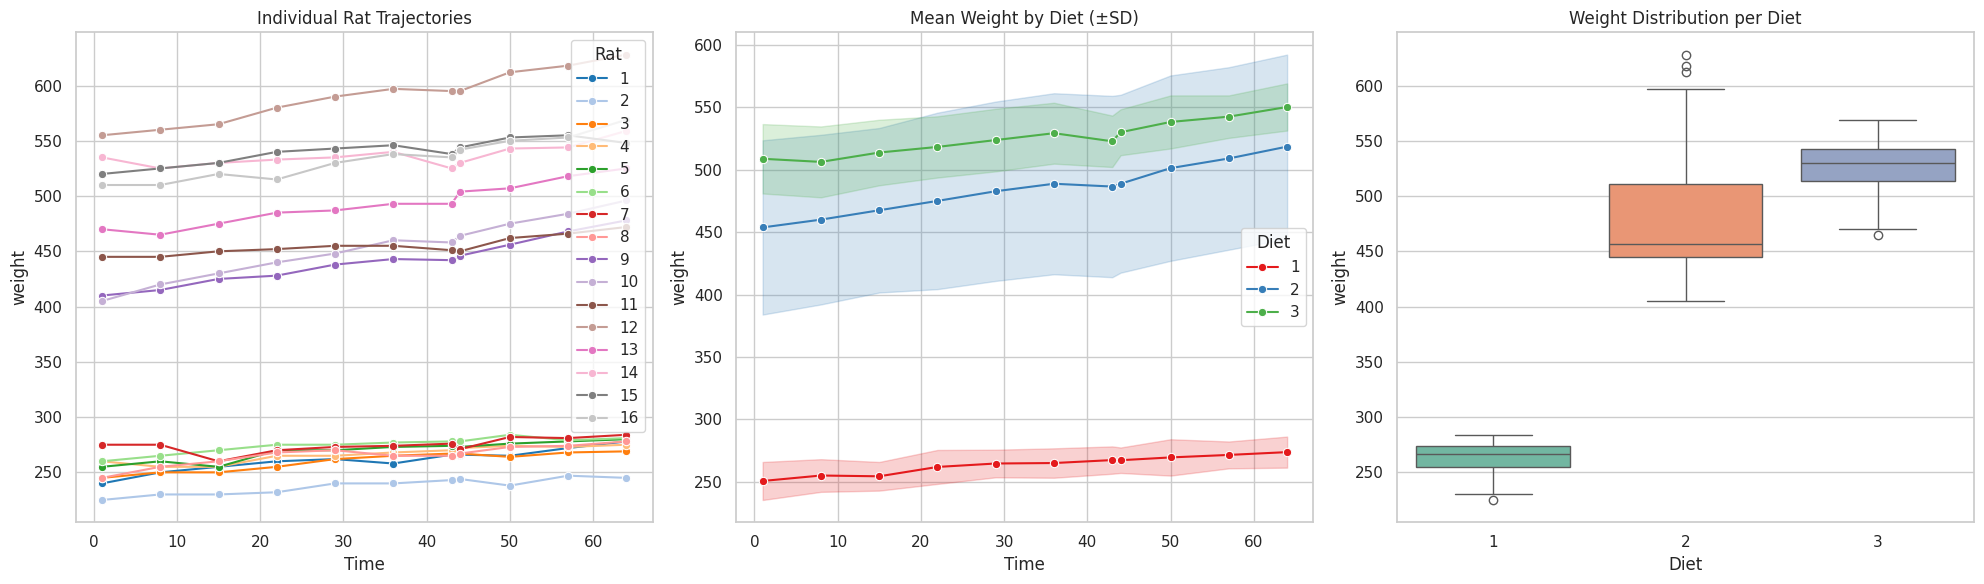

In [329]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sns.lineplot(ax=axes[0], x='Time', y='weight', hue='Rat', data=bw, marker='o', palette='tab20').set(title="Individual Rat Trajectories")
sns.lineplot(ax=axes[1], x='Time', y='weight', hue='Diet', data=bw, ci='sd', marker='o', palette='Set1').set(title="Mean Weight by Diet (±SD)")
sns.boxplot(ax=axes[2], x='Diet', y='weight', data=bw, palette='Set2').set(title="Weight Distribution per Diet")

plt.tight_layout()
plt.show()


###Visualization - Correlation

The correlation matrix shows a strong positive association between weight and Diet (r ≈ 0.91), indicating that heavier rats are in higher diet groups. Weight is weakly correlated with Time (r ≈ 0.09), and Time and Diet are essentially uncorrelated, suggesting that diet differences, rather than time, drive most of the variation in weight.


Correlation matrix:
           weight          Time          Diet
weight  1.000000  8.985468e-02  9.103610e-01
Time    0.089855  1.000000e+00 -3.979657e-16
Diet    0.910361 -3.979657e-16  1.000000e+00


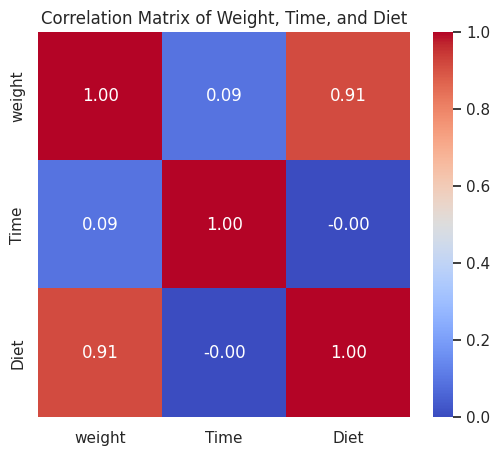

In [330]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix (numeric columns only)
corr_matrix = bw[['weight', 'Time', 'Diet']].corr()
print("Correlation matrix:\n", corr_matrix)

# Visualize correlations
plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Weight, Time, and Diet")
plt.show()


###LME

The Linear Mixed-Effects Model shows that both Time and Diet significantly affect rat weight. The intercept (≈121.2 g) represents baseline weight. Each additional day increases weight by ~0.59 g (p<0.001), while diet group increases weight by ~139.2 g (p<0.001), indicating that diet has a stronger effect than time. Random intercept variance (≈2922.6) reflects substantial between-rat variability, confirming the importance of accounting for repeated measures. The model converged successfully with 16 rats and 176 observations. Overall, results highlight that diet is the primary driver of weight differences, with time contributing modestly, and individual rat differences remain significant.


In [331]:
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm

# Fit LME: weight ~ Time + Diet, random intercept for Rat
lme_model = mixedlm("weight ~ Time + Diet", bw, groups=bw["Rat"])
lme_result = lme_model.fit()

# Summary of model
print(lme_result.summary())


         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: weight   
No. Observations:  176     Method:             REML     
No. Groups:        16      Scale:              66.8554  
Min. group size:   11      Log-Likelihood:     -662.7754
Max. group size:   11      Converged:          Yes      
Mean group size:   11.0                                 
--------------------------------------------------------
           Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------
Intercept  121.206   31.615  3.834 0.000  59.241 183.171
Time         0.586    0.032 18.486 0.000   0.524   0.648
Diet       139.217   16.317  8.532 0.000 107.237 171.197
Group Var 2922.555  141.187                             



##GEE

In [332]:
import statsmodels.api as sm
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.families import Gaussian
from statsmodels.genmod.cov_struct import Exchangeable

# Fit GEE: weight ~ Time + Diet, clusters by Rat
gee_model = GEE.from_formula(
    "weight ~ Time + Diet",
    groups="Rat",
    data=bw,                 # your dataframe
    cov_struct=Exchangeable(),
    family=Gaussian()
)
gee_result = gee_model.fit()
print(gee_result.summary())


                               GEE Regression Results                              
Dep. Variable:                      weight   No. Observations:                  176
Model:                                 GEE   No. clusters:                       16
Method:                        Generalized   Min. cluster size:                  11
                      Estimating Equations   Max. cluster size:                  11
Family:                           Gaussian   Mean cluster size:                11.0
Dependence structure:         Exchangeable   Num. iterations:                     2
Date:                     Mon, 17 Nov 2025   Scale:                        2668.908
Covariance type:                    robust   Time:                         15:18:55
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    121.2063     13.757      8.810      0.000      94.242     148.170
Time   

The GEE results show a significant Intercept of 121.21 (SE = 13.76, p < 0.001), indicating baseline weight. Time has a positive effect of 0.586 per unit (SE = 0.085, p < 0.001), while Diet increases weight by 139.22 (SE = 10.26, p < 0.001). The exchangeable correlation structure accounts for clustering within 16 subjects, each with 11 observations. Robust standard errors ensure reliable inference despite within-subject correlation. Both time progression and dietary treatment substantially contribute to weight gain, with all effects highly statistically significant.


###F) Example 2 : Spine Injury Dataset

**Goal:**  
We want to analyze the progression of functional recovery (FIM scores) over time in spinal cord injury patients, while accounting for:

- **Repeated measurements per subject** – the same patient is measured multiple times (longitudinal).  
- **Fixed effects** – factors like time, sex, AIS_grade, or site that affect the outcome systematically.  
- **Random effects** – subject-specific deviations from the average trajectory.  

**Ultimate aim:**  

- Model the temporal evolution of `rasch_FIM` (or `rasch_FIM_LOCF`).  
- Quantify how much recovery is explained by fixed versus random effects.  
- Enable prediction of future functional outcomes for new patients or time points.


The dataset has 720 rows × 10 columns with the following variables:

| Column             | Description                               |
|-------------------|-------------------------------------------|
| subID             | Participant ID                             |
| site              | Site of data collection                     |
| AIS_grade         | Injury severity grade                       |
| month             | Month of measurement                        |
| time              | Time in weeks or months (continuous)       |
| sex               | Participant sex                             |
| rasch_FIM         | Rasch-transformed FIM score                 |
| rasch_FIM_MAR     | Score with Missing At Random imputation    |
| rasch_FIM_MNAR    | Score with Missing Not At Random imputation|
| rasch_FIM_LOCF    | Last Observation Carried Forward imputation|

**Key observations:**

- Multiple measurements per participant → confirms **longitudinal structure**.  
- Some missing values present (NaN) in certain imputed columns.


In [333]:
import pandas as pd

# Load spine injury dataset
url = "https://raw.githubusercontent.com/keithlohse/LMER_Clinical_Science/master/ACRM_2018/data/data_session1.csv"
data2 = pd.read_csv(url)
data2

,subID,site,AIS_grade,month,time,sex,rasch_FIM,rasch_FIM_MAR,rasch_FIM_MNAR,rasch_FIM_LOCF
0,s01,D,C5-8,1,1.16,f,12.560000,12.560000,12.560000,12.560000
1,s01,D,C5-8,2,2.58,f,24.854467,24.854467,24.854467,24.854467
2,s01,D,C5-8,3,3.69,f,40.278629,NaN,40.278629,40.278629
3,s01,D,C5-8,4,4.92,f,43.868933,NaN,43.868933,43.868933
4,s01,D,C5-8,5,5.16,f,47.665344,NaN,47.665344,47.665344
...,...,...,...,...,...,...,...,...,...,...
715,s40,B,C5-8,14,14.95,m,52.278991,52.278991,NaN,46.621699
716,s40,B,C5-8,15,15.54,m,53.251093,NaN,NaN,46.621699
717,s40,B,C5-8,16,16.01,m,53.821724,NaN,NaN,46.621699
718,s40,B,C5-8,17,17.04,m,54.398344,NaN,NaN,46.621699


From the `info()` output, here’s a summary of the variables for modeling:

- **subID (object):** Subject identifier → serves as the **random effect grouping factor**.  
- **site (object):** Clinical site → can be used as a **fixed effect** or covariate.  
- **AIS_grade (object):** Injury severity → **fixed effect categorical predictor**.  
- **month (int64) & time (float64):** Longitudinal time variables → **fixed effect**.  
- **sex (object):** Biological sex → **fixed effect categorical predictor**.  
- **rasch_FIM (float64):** Main response variable (complete) → for **mixed-effects modeling**.  
- **rasch_FIM_MAR / MNAR (float64):** Partial missing data → could be used for **imputation comparisons**.  
- **rasch_FIM_LOCF (float64):** Response with last-observation-carried-forward → **alternative response variable**.  

We now have all the ingredients for longitudinal modeling, including **mixed-effects models, GLMs, or GEE**, depending on distributional assumptions.


#### Drop specific columns

In [334]:
data2_clean = data2.drop(columns=['rasch_FIM_MAR', 'rasch_FIM_MNAR'])
data2_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   subID           720 non-null    object 
 1   site            720 non-null    object 
 2   AIS_grade       720 non-null    object 
 3   month           720 non-null    int64  
 4   time            720 non-null    float64
 5   sex             720 non-null    object 
 6   rasch_FIM       720 non-null    float64
 7   rasch_FIM_LOCF  720 non-null    float64
dtypes: float64(3), int64(1), object(4)
memory usage: 45.1+ KB


The dataset now has 720 complete rows with 8 columns, all non-null, ready for downstream analysis and modeling.

In [335]:
data2_clean

,subID,site,AIS_grade,month,time,sex,rasch_FIM,rasch_FIM_LOCF
0,s01,D,C5-8,1,1.16,f,12.560000,12.560000
1,s01,D,C5-8,2,2.58,f,24.854467,24.854467
2,s01,D,C5-8,3,3.69,f,40.278629,40.278629
3,s01,D,C5-8,4,4.92,f,43.868933,43.868933
4,s01,D,C5-8,5,5.16,f,47.665344,47.665344
...,...,...,...,...,...,...,...,...
715,s40,B,C5-8,14,14.95,m,52.278991,46.621699
716,s40,B,C5-8,15,15.54,m,53.251093,46.621699
717,s40,B,C5-8,16,16.01,m,53.821724,46.621699
718,s40,B,C5-8,17,17.04,m,54.398344,46.621699


#Data Cleaning-Mapping
###AIS_grade_code   

In [336]:
# Unique values in AIS_grade
data2_clean['AIS_grade'].unique()


array(['C5-8', 'T1-S5', 'C1-4'], dtype=object)

In [337]:
data2_clean['AIS_grade_code'] = data2_clean['AIS_grade'].map({'C1-4': 1, 'C5-8': 2, 'T1-S5': 3})

### Sex

In [338]:
data2_clean['sex'].unique()

array(['f', 'm'], dtype=object)

In [339]:
data2_clean['sex_code'] = data2_clean['sex'].map({'f': 0, 'm': 1})

### Site

In [340]:
data2_clean['site'].unique()


array(['D', 'B', 'C', 'A'], dtype=object)

In [341]:
data2_clean['site'] = data2_clean['site'].map({'A':1,'B':2,'C':3,'D':4})


In [342]:
data2_clean

,subID,site,AIS_grade,month,time,sex,rasch_FIM,rasch_FIM_LOCF,AIS_grade_code,sex_code
0,s01,4,C5-8,1,1.16,f,12.560000,12.560000,2,0
1,s01,4,C5-8,2,2.58,f,24.854467,24.854467,2,0
2,s01,4,C5-8,3,3.69,f,40.278629,40.278629,2,0
3,s01,4,C5-8,4,4.92,f,43.868933,43.868933,2,0
4,s01,4,C5-8,5,5.16,f,47.665344,47.665344,2,0
...,...,...,...,...,...,...,...,...,...,...
715,s40,2,C5-8,14,14.95,m,52.278991,46.621699,2,1
716,s40,2,C5-8,15,15.54,m,53.251093,46.621699,2,1
717,s40,2,C5-8,16,16.01,m,53.821724,46.621699,2,1
718,s40,2,C5-8,17,17.04,m,54.398344,46.621699,2,1


#Stratified longitudinal trajectories for the outcome rasch_FIM_LOCF:

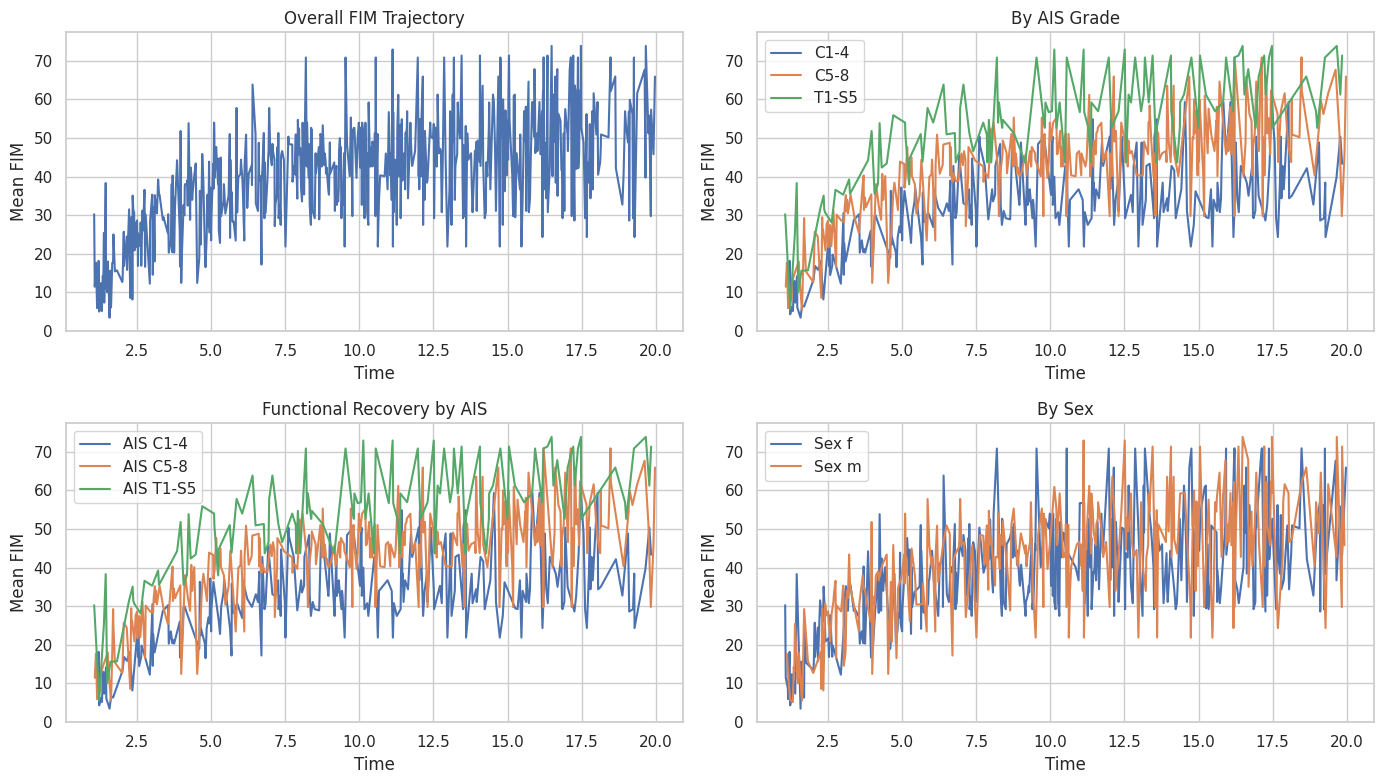

In [343]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# 1. Overall trajectory
mean_all = data2_clean.groupby('time')['rasch_FIM_LOCF'].mean()
axes[0,0].plot(mean_all); axes[0,0].set_title("Overall FIM Trajectory")

# 2. By AIS grade
for g, df in data2_clean.groupby("AIS_grade"):
    axes[0,1].plot(df.groupby("time")["rasch_FIM_LOCF"].mean(), label=g)
axes[0,1].set_title("By AIS Grade"); axes[0,1].legend()

# 3. By AIS grade (variant kept for completeness)
for g, df in data2_clean.groupby("AIS_grade"):
    axes[1,0].plot(df.groupby("time")["rasch_FIM_LOCF"].mean(), label=f"AIS {g}")
axes[1,0].set_title("Functional Recovery by AIS"); axes[1,0].legend()

# 4. By sex
for s, df in data2_clean.groupby("sex"):
    axes[1,1].plot(df.groupby("time")["rasch_FIM_LOCF"].mean(), label=f"Sex {s}")
axes[1,1].set_title("By Sex"); axes[1,1].legend()

for ax in axes.ravel():
    ax.set_xlabel("Time"); ax.set_ylabel("Mean FIM"); ax.grid(True)

plt.tight_layout(); plt.show()


###Summary statistics

In [344]:
data2_clean.describe()

,site,month,time,rasch_FIM,rasch_FIM_LOCF,AIS_grade_code,sex_code
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,2.325000,9.500000,10.012597,44.904418,40.896390,1.825000,0.475000
std,1.082128,5.191734,5.264500,16.354582,14.540849,0.703607,0.499722
min,1.000000,1.000000,1.040000,3.453333,3.453333,1.000000,0.000000
25%,1.000000,5.000000,5.417500,32.981337,30.702970,1.000000,0.000000
50%,2.000000,9.500000,10.000000,46.641702,42.605257,2.000000,0.000000
75%,3.000000,14.000000,14.587500,57.020123,50.915614,2.000000,1.000000
max,4.000000,18.000000,19.980000,81.913240,73.856377,3.000000,1.000000


The dataset of 720 observations has a mean Rasch FIM (LOCF) of 40.90 (SD = 14.54, min = 3.45, max = 73.86), measured over time with a mean of 10.01 months (SD = 5.26). Subjects come from sites 1–4 (mean = 2.33) and are mostly AIS grade 1–3 (mean code = 1.83). The sex distribution is near balanced (mean = 0.475). Rasch FIM values show considerable variability, with interquartile range 30.70–50.92, indicating heterogeneous recovery trajectories. The increase in mean FIM over time suggests overall functional improvement, while differences across sites, AIS grades, and sex highlight the influence of baseline injury severity and demographic factors on recovery patterns.


# longitudinal trajectories

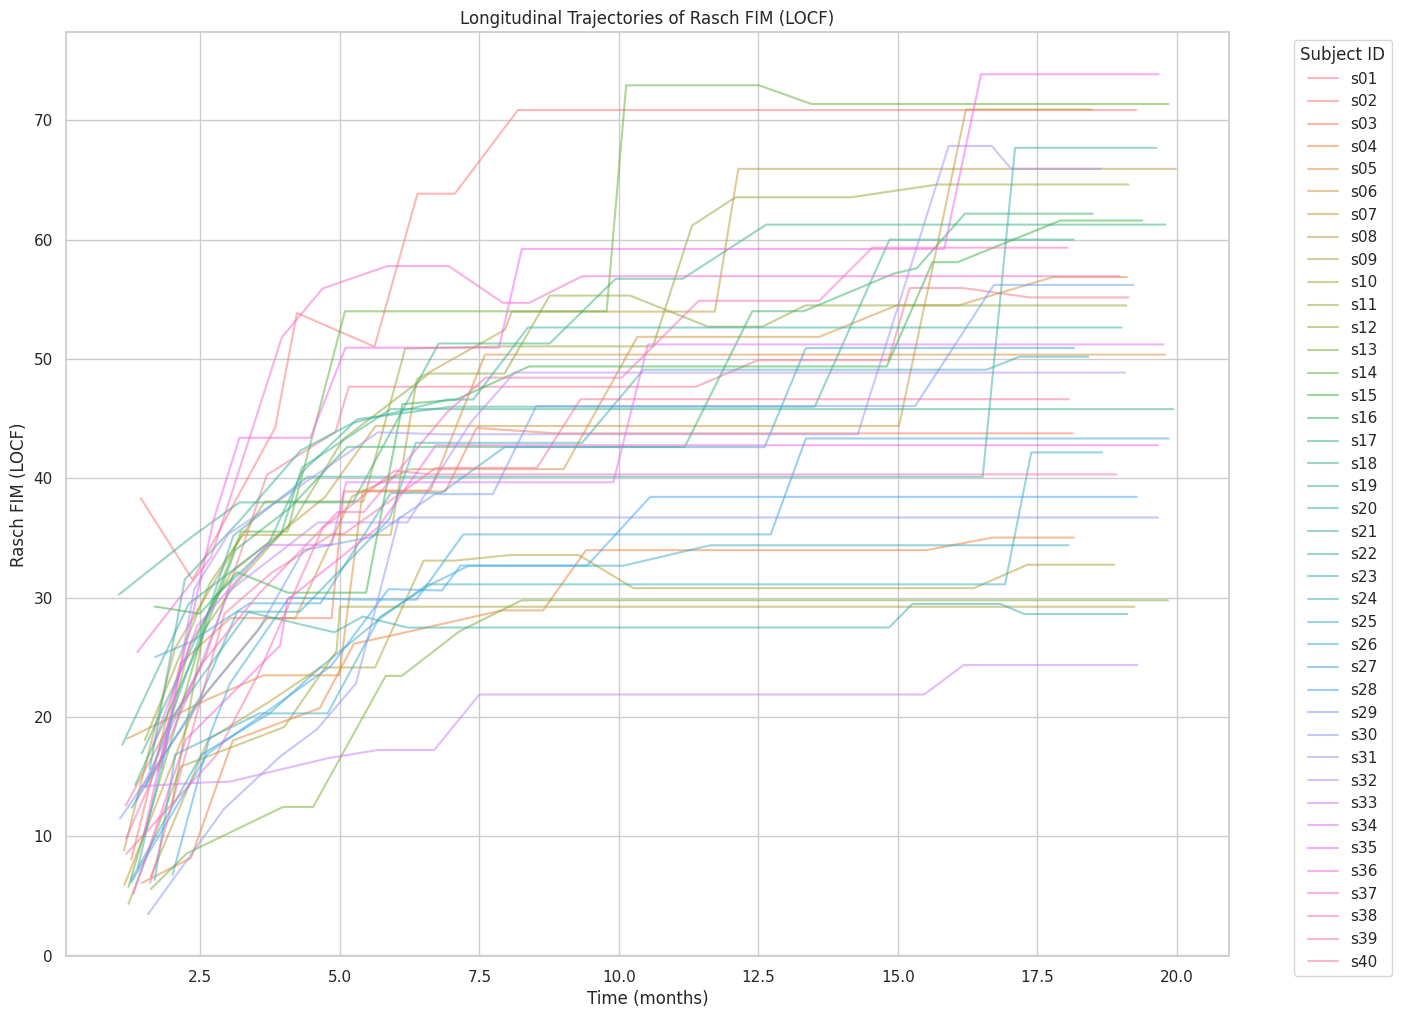

In [345]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,12))
sns.lineplot(
    x='time',
    y='rasch_FIM_LOCF',
    hue='subID',
    data=data2_clean,
    legend='full',   # show full legend for all subIDs
    alpha=0.5
)
plt.title("Longitudinal Trajectories of Rasch FIM (LOCF)")
plt.xlabel("Time (months)")
plt.ylabel("Rasch FIM (LOCF)")
plt.legend(title="Subject ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


##Correlation Analysis

In [346]:
data2_clean[['month', 'time', 'rasch_FIM', 'rasch_FIM_LOCF', 'AIS_grade_code', 'sex_code']].corr()


,month,time,rasch_FIM,rasch_FIM_LOCF,AIS_grade_code,sex_code
month,1.000000e+00,0.997915,0.684020,0.603918,-2.738292e-16,5.594593e-16
time,9.979153e-01,1.000000,0.680555,0.600904,-1.243863e-03,-2.550839e-05
rasch_FIM,6.840199e-01,0.680555,1.000000,0.935222,4.567391e-01,9.416000e-02
rasch_FIM_LOCF,6.039175e-01,0.600904,0.935222,1.000000,5.018089e-01,1.063095e-01
AIS_grade_code,-2.738292e-16,-0.001244,0.456739,0.501809,1.000000e+00,1.655420e-01
sex_code,5.594593e-16,-0.000026,0.094160,0.106310,1.655420e-01,1.000000e+00


The correlation matrix reveals strong positive associations between `month` and `time` (≈0.998), indicating nearly identical progression measures. `rasch_FIM` and `rasch_FIM_LOCF` are highly correlated (0.935), reflecting consistent functional recovery measurements. Moderate positive correlations exist between FIM scores and `AIS_grade_code` (≈0.46–0.50), suggesting that higher impairment grades relate to higher FIM outcomes. `sex_code` shows very weak correlations with all variables (<0.11), indicating minimal influence of sex on these measures over time.


#LME

**Model**

For subject $i$ and measurement $j$:

$$
Y_{ij} = \beta_0 + \beta_1 \, \texttt{time}_{ij} + \beta_2 \, \texttt{sex_code}_{ij} + \beta_3 \, \texttt{AIS_grade_code}_{ij} + \beta_4 \, \texttt{site}_{ij} + b_i + \varepsilon_{ij}
$$

where:

$$
Y_{ij} = \texttt{rasch_FIM_LOCF}_{ij}
$$

$$
b_i \sim \mathcal{N}(0, \sigma_b^2)
$$
is the random intercept for subject $i$.

$$
\varepsilon_{ij} \sim \mathcal{N}(0, \sigma^2)
$$
is the residual error.

**Matrix form:**

$$
Y = X \beta + Z b + \varepsilon
$$

Estimated using **REML**.


In [347]:
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm

# Define the LME model
# Random intercept per subject (subID)
lme_model = mixedlm(
    "rasch_FIM_LOCF ~ time + sex_code + AIS_grade_code + site",  # Fixed effects
    data=data2_clean,
    groups=data2_clean["subID"]              # Random effect
)

# Fit the model using REML
lme_result = lme_model.fit(reml=True)

# Summary of results
print(lme_result.summary())


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: rasch_FIM_LOCF
No. Observations: 720     Method:             REML          
No. Groups:       40      Scale:              45.7975       
Min. group size:  18      Log-Likelihood:     -2448.8171    
Max. group size:  18      Converged:          Yes           
Mean group size:  18.0                                      
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          2.374    3.705  0.641 0.522 -4.887  9.635
time               1.662    0.048 34.665 0.000  1.568  1.756
sex_code           0.934    2.063  0.453 0.651 -3.110  4.978
AIS_grade_code    10.317    1.458  7.074 0.000  7.459 13.176
site               1.122    0.940  1.194 0.233 -0.720  2.964
Group Var         38.361    1.462                           



The mixed-effects model for Rasch FIM (LOCF) includes 720 observations across 40 groups with equal sizes (18 per group) and converged successfully using REML. The intercept is 2.37 (SE = 3.71, p = 0.522), indicating a low baseline when other covariates are zero. Time is strongly significant (coef = 1.662, SE = 0.048, p < 0.001), showing consistent functional improvement over measurement points. AIS grade also strongly predicts outcomes (coef = 10.317, SE = 1.458, p < 0.001), reflecting higher impairment codes correspond to greater FIM improvement. Sex (p = 0.651) and site (p = 0.233) are non-significant. Between-group variability is notable (Group Var = 38.361), suggesting substantial differences across subjects.


###GEE

For subject $i$ and observation $j$:

$$
g(\mu_{ij}) = \beta_0 + \beta_1 \, \text{time}_{ij} + \beta_2 \, \text{sex_code}_{ij} + \beta_3 \, \text{AIS_grade_code}_{ij} + \beta_4 \, \text{site}_{ij},
$$

where:

- $Y_{ij}$ is the response:
  - $Y_{ij} = \text{rasch_FIM_LOCF}_{ij}$ for Gaussian/Gamma family  
  - $Y_{ij} = \text{rasch_FIM_LOCF_int}_{ij}$ for Poisson family

- $g(\cdot)$ is the link function:

$$
g(\mu) =
\begin{cases}
\mu & \text{Gaussian family} \\
\log(\mu) & \text{Poisson family} \\
\log(\mu) & \text{Gamma family}
\end{cases}
$$

The working correlation accounts for repeated measures within subject $i$:

$$
\text{corr}(Y_{ij}, Y_{ik}) = R(\alpha), \quad j \neq k.
$$

GEE estimates $\beta$ by solving:

$$
\sum_{i=1}^{N} D_i^\top V_i^{-1} (Y_i - \mu_i) = 0,
$$

where $V_i$ is constructed using the chosen family and working correlation structure.


In [348]:
import statsmodels.api as sm
from statsmodels.genmod.families import Gaussian, Poisson, Gamma

# List of valid families
families = [Gaussian(), Poisson(), Gamma()]

# Ensure Poisson compatibility: round rasch_FIM_LOCF
gee_data = data2_clean.copy()
gee_data['rasch_FIM_LOCF_int'] = gee_data['rasch_FIM_LOCF'].round().astype(int)

# Dictionary to store results
gee_results = {}

for fam in families:
    endog = 'rasch_FIM_LOCF_int' if isinstance(fam, Poisson) else 'rasch_FIM_LOCF'

    model = sm.GEE.from_formula(
        f"{endog} ~ time + sex_code + AIS_grade_code + site",
        groups="subID",
        data=gee_data,
        family=fam
    )
    result = model.fit()
    gee_results[fam.__class__.__name__] = result

    print(f"\n=== Summary for {fam.__class__.__name__} Family ===\n")
    print(result.summary())



=== Summary for Gaussian Family ===

                               GEE Regression Results                              
Dep. Variable:              rasch_FIM_LOCF   No. Observations:                  720
Model:                                 GEE   No. clusters:                       40
Method:                        Generalized   Min. cluster size:                  18
                      Estimating Equations   Max. cluster size:                  18
Family:                           Gaussian   Mean cluster size:                18.0
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Mon, 17 Nov 2025   Scale:                          80.562
Covariance type:                    robust   Time:                         15:18:58
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.3785      2.934    

The GEE analyses summarize marginal effects of predictors on Rasch FIM (LOCF) across 40 clusters (subjects) with 18 measurements each.

For the **Gaussian family**, the intercept is 2.3785 (SE = 2.934, p = 0.418), time strongly predicts functional improvement (coef = 1.6616, SE = 0.088, p < 0.001), AIS grade is highly significant (coef = 10.3173, SE = 1.563, p < 0.001), while sex (p = 0.659) and site (p = 0.198) are not.

Using the **Poisson family**, coefficients are smaller but show similar trends: time (coef = 0.0408, SE = 0.002, p < 0.001) and AIS grade (coef = 0.2487, SE = 0.039, p < 0.001) remain significant.

For the **Gamma family**, effects are scaled differently: time (coef = -0.0010, SE = 5.01e-05, p < 0.001) and AIS grade (coef = -0.0056, SE = 0.001, p < 0.001) are significant, while sex and site are not.

Across all models, **time** and **AIS grade** consistently influence recovery, highlighting the robustness of these predictors regardless of assumed distribution.


#PART B : GEE

###a) Key Assumptions

Generalized Estimating Equations (GEE) extend Generalized Linear Models (GLMs) to handle grouped or correlated data, such as panel, clustered, or longitudinal datasets.

---

## 1. Independence Assumption Is Relaxed

In GLMs, responses $Y$ are assumed i.i.d.  

In GEE, repeated observations within a subject are correlated. The variance is specified as:

$$
\text{Var}(Y_{ij}) = \phi \, V(\mu_{ij}), \ a(\phi), \ R(\rho),
$$

where:  

- $\phi$ = dispersion parameter  
- $V(\mu_{ij})$ = GLM variance function  
- $R(\rho)$ = working correlation structure (e.g., Independent, Exchangeable, AR(1))  

---

## 2. Outcome Need Not Follow an Exponential Family

Unlike GLMs, GEE is more flexible. The response variable $Y$ does not need to strictly follow an exponential family distribution. The key is specifying a reasonable variance function and correlation structure for the grouped data.

---

## 3. Mean Linked to Covariates Through a GLM-Style Link Function

GEE retains the systematic component of GLMs:

$$
g(\mu_{ij}) = X_{ij}^\top \beta,
$$

where:  

- $g(\cdot)$ = link function  
- $X_{ij}$ = covariates  
- $\beta$ = parameters to estimate  

---

**Reference Video (27 mins):**  
[Click here](https://youtu.be/ROdkmShnwoA?si=gPO-7XwvdLM5b5Ut)


# GEE: Hypothesized Covariance Structures

In GEE, a working (hypothesized) correlation structure describes how repeated observations within the same subject are related. While $\beta$ estimates remain consistent even if the structure is misspecified, the choice affects efficiency.

---

## 1. Identity Correlation Matrix (Independence)

Assumes all repeated responses are uncorrelated:

$$
R =
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1
\end{bmatrix}
$$

---

## 2. Autoregressive Structure (AR(1))

Correlation decays with the time lag between observations:

$$
R =
\begin{bmatrix}
1 & \rho & \rho^2 \\
\rho & 1 & \rho \\
\rho^2 & \rho & 1
\end{bmatrix}
$$

---

## 3. Exchangeable (Compound Symmetry)

All pairs of observations share the same correlation:

$$
R =
\begin{bmatrix}
1 & \rho & \rho \\
\rho & 1 & \rho \\
\rho & \rho & 1
\end{bmatrix}
$$

---

## 4. Unstructured Correlation

Each pair of time points has its own correlation parameter:

$$
R =
\begin{bmatrix}
1 & \rho_{12} & \rho_{13} \\
\rho_{21} & 1 & \rho_{23} \\
\rho_{31} & \rho_{32} & 1
\end{bmatrix}
$$

This is the most flexible form but requires more data to estimate reliably.

---

**Note:**  

In this course, the focus is on implementing and interpreting GEE models in Python (and parallel examples in R). As you advance, you will learn how the choice of correlation structure affects efficiency and inference.


##b) Multilevel Models vs. GEE

---

## 1. Conceptual Difference

- **GEE**: Marginal (population-averaged) model; estimates how the **average person** in the population responds.  
- **Mixed-effects / multilevel models**: Subject-specific (conditional); estimates effects **within each subject or cluster**, allowing random intercepts and slopes.

---

## 2. Interpretation

- **GEE parameters**: Expected change in the **population mean** of the response.  
- **Multilevel model parameters**: Change in an individual’s trajectory, conditional on their random effects.

---

## 3. Modeling Flexibility

- **GEE**: Handles simple repeated measures or clustering; limited for complex structures (e.g., nested time within subjects within centers, crossed random effects).  
- **Mixed-effects models**: Excels with nested or crossed hierarchies.

---

## 4. Computation

- **GEE**: Not likelihood-based; computation is typically faster and stable for large samples.  
- **Mixed-effects**: Likelihood-based; computationally heavier, especially with multiple random effects.

---

## 5. Inference and Simulation

- **GEE**: Cannot be directly used for simulation or likelihood-based predictions.  
- **Mixed-effects**: Produces a complete likelihood; can be used for predictions, simulations, and likelihood-ratio tests.

---

## 6. Correlation Structure

- **GEE**: User-specified working correlation (AR(1), exchangeable, unstructured, etc.), encoding ideas like “closer measurements in time are more correlated.”  
- **Many mixed-effects frameworks**: Do not allow explicit residual correlation structures.

---

## Applied Example: Depression Dataset

- **Subjects**: 340, measured at three time points  
- **Grouping factors**: `diagnose` (mild vs. severe), `drug` (standard vs. new)  
- **Response**: Binary depression indicator (1 = “Normal”)  

### Observations

- All subgroups improve over time.  
- Subjects receiving the **new drug** show a stronger increase in normal responses.  
- This reflects **marginal (population-level) trajectories**, making it ideal for **GEE**, which models average changes while accounting for repeated measures.


In [349]:
import pandas as pd

# URL of the dataset
url = "http://static.lib.virginia.edu/statlab/materials/data/depression.csv"

# Read the dataset
dat = pd.read_csv(url)
dat

,diagnose,drug,id,time,depression
0,mild,standard,1,0,1
1,mild,standard,1,1,1
2,mild,standard,1,2,1
3,mild,standard,2,0,1
4,mild,standard,2,1,1
...,...,...,...,...,...
1015,severe,new,339,1,0
1016,severe,new,339,2,0
1017,severe,new,340,0,0
1018,severe,new,340,1,0


The dataset has been loaded successfully and contains **1,021 rows × 5 columns**:

| Column      | Description                                 |
|------------|---------------------------------------------|
| diagnose   | Severity category (mild, moderate, severe) |
| drug       | Treatment group (standard or new)           |
| id         | Subject identifier                           |
| time       | Measurement time                             |
| depression | Outcome measure                               |

This structure supports **longitudinal analysis**, as multiple measurements are recorded per subject (`id`) over time, enabling assessment of treatment effects and temporal changes in depression severity.


In [350]:
# Convert to categorical
dat['id'] = dat['id'].astype('category')
dat['drug'] = dat['drug'].astype('category')
dat['diagnose'] = dat['diagnose'].astype('category')

In [351]:
# Total number of subjects
n_subjects = dat['id'].nunique()
print(f"Altogether we have {n_subjects} subjects\n")

Altogether we have 340 subjects



In [352]:
# Compute proportion of "Normal" responses (depression == 1) by diagnose, drug, and time
prop_table = dat.groupby(['diagnose', 'drug', 'time'])['depression'].mean()
prop_table

diagnose  drug      time
mild      new       0       0.528571
                    1       0.785714
                    2       0.971429
          standard  0       0.512500
                    1       0.587500
                    2       0.675000
severe    new       0       0.177778
                    1       0.500000
                    2       0.833333
          standard  0       0.210000
                    1       0.280000
                    2       0.460000
Name: depression, dtype: float64

This table shows the proportion of “normal” depression responses (coded as 1) over time, stratified by diagnosis (mild vs severe) and drug (new vs standard).

For **mild patients**, the proportion of normal responses increases over time for both drugs: new rises from 0.529 → 0.971, while standard rises more slowly from 0.513 → 0.675.

For **severe patients**, the increase is more dramatic with the new drug (0.178 → 0.833) compared to standard (0.210 → 0.460).

**Insight:** The new drug consistently produces faster improvement, particularly in severe cases, highlighting its potential efficacy in accelerating recovery. Time is clearly associated with improvement across all groups.


In [353]:
# Flatten the multi-index table
prop_table = prop_table.reset_index()
prop_table

,diagnose,drug,time,depression
0,mild,new,0,0.528571
1,mild,new,1,0.785714
2,mild,new,2,0.971429
3,mild,standard,0,0.512500
4,mild,standard,1,0.587500
5,mild,standard,2,0.675000
6,severe,new,0,0.177778
7,severe,new,1,0.500000
8,severe,new,2,0.833333
9,severe,standard,0,0.210000


In [354]:
# Pivot to make time columns
prop_table_pivot = prop_table.pivot_table(index=['diagnose', 'drug'], columns='time', values='depression')
prop_table_pivot

time                      0         1         2
diagnose drug                                  
mild     new       0.528571  0.785714  0.971429
         standard  0.512500  0.587500  0.675000
severe   new       0.177778  0.500000  0.833333
         standard  0.210000  0.280000  0.460000

##c) GEE to Estimate Parameters in Python

Generalized Estimating Equations (GEE) are used to analyze **longitudinal or clustered data**, estimating **population-averaged effects** rather than subject-specific effects. The Python implementation closely resembles mixed-effects model syntax.

---

## Model Specification

- **Formula**: Defines outcome and predictors, for example:

$$
\text{depression} \sim \text{diagnose} + \text{drug} \times \text{time}
$$

- **groups**: Identifies repeated observations belonging to each subject (`id`).  
- **family**: `Binomial()` is used for a binary outcome, modeling probabilities.  
- **cov_struct**: Specifies the within-subject correlation pattern:

| Structure | Description |
|-----------|-------------|
| `Independence()` | Assumes no correlation between repeated measures |
| `Exchangeable()` | Constant correlation across time points |
| `Autoregressive()` | Correlation decays with increasing time lag |

---

## Interpretation

After fitting the model, the output provides:

- Estimated regression coefficients ($\beta$)  
- Robust standard errors  
- Population-level effects of `diagnose`, `drug`, `time`, and their interaction  

These estimates describe how each factor affects the **overall probability of a normal depression response** across all individuals, while correctly accounting for the repeated-measure structure.


In [355]:
import statsmodels.api as sm
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.cov_struct import Independence

# Define formula with interaction
formula = "depression ~ diagnose + drug*time"

# Fit GEE model
gee_model = sm.GEE.from_formula(
    formula,
    groups="id",                  # Grouping factor (subject ID)
    data=dat,                     # Dataset
    family=Binomial(),            # Binary outcome
    cov_struct=Independence()     # Correlation structure
)
gee_result = gee_model.fit()

# Display estimated coefficients
print(gee_result.summary())


                               GEE Regression Results                              
Dep. Variable:                  depression   No. Observations:                 1020
Model:                                 GEE   No. clusters:                      340
Method:                        Generalized   Min. cluster size:                   3
                      Estimating Equations   Max. cluster size:                   3
Family:                           Binomial   Mean cluster size:                 3.0
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Mon, 17 Nov 2025   Scale:                           1.000
Covariance type:                    robust   Time:                         15:18:59
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.0876      0.184     -0.477      0.63

This GEE model estimates the marginal effects of **diagnosis**, **drug**, and **time** on the binary depression outcome, accounting for repeated measures within subjects (`id`).

- **Intercept** (-0.088, p = 0.634): Baseline log-odds for mild patients on the new drug at time 0, not significantly different from zero.  
- **Diagnosis severe** (-1.314, p < 0.001): Severe patients have significantly lower odds of normal depression response than mild patients.  
- **Drug standard** (0.060, p = 0.794): No significant baseline difference between standard and new drug.  
- **Time** (1.500, p < 0.001): Each additional time unit increases odds of normal response.  
- **Interaction drug:time** (-1.017, p < 0.001): Improvement over time is smaller with the standard drug than new.

**Insight:** Time strongly improves outcomes, and the new drug accelerates recovery, especially for severe cases.


##d) GEE Model Interpretation: Depression Study

This GEE model estimates the marginal effects of **diagnosis**, **drug**, and **time** on the binary depression outcome, accounting for repeated measures within subjects (`id`).

- **Intercept** (-0.088, p = 0.634): Baseline log-odds for mild patients on the new drug at time 0, not significantly different from zero.  
- **Diagnosis severe** (-1.314, p < 0.001): Severe patients have significantly lower odds of normal depression response than mild patients.  
- **Drug standard** (0.060, p = 0.794): No significant baseline difference between standard and new drug.  
- **Time** (1.500, p < 0.001): Each additional time unit increases odds of normal response.  
- **Interaction drug:time** (-1.017, p < 0.001): Improvement over time is smaller with the standard drug than new.

---

## Key Insights

1. **Treatment efficacy**  
   The new drug leads to faster improvement compared to the standard drug.

2. **Severity matters**  
   Severe diagnosis reduces baseline recovery probability, emphasizing the need for early or aggressive intervention.

3. **Time dynamics**  
   Recovery is strongly time-dependent, and the drug type modulates this progression.

---

## Practical Implication

Clinicians should consider **both diagnosis severity and treatment type** when predicting recovery trajectories.  
The new drug is particularly beneficial for severe cases, **accelerating functional recovery over time**.


##e) GEE Vs binomial family
GEE with a binomial family produces results similar to GLM with quasibinomial, accounting for over-dispersion; both estimate marginal effects, but GEE adds within-subject correlation handling.

In [356]:
import statsmodels.api as sm
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.cov_struct import Exchangeable

# 1. GLM (quasibinomial-like)
glm_res = sm.GLM.from_formula("depression ~ diagnose + drug*time",
                              data=dat, family=Binomial()).fit(scale='X2')
print(glm_res.summary())

# 2. GEE with exchangeable correlation
gee_res = GEE.from_formula("depression ~ diagnose + drug*time",
                           groups="id", data=dat,
                           family=Binomial(), cov_struct=Exchangeable()).fit()
print(gee_res.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:             depression   No. Observations:                 1020
Model:                            GLM   Df Residuals:                     1015
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                         0.98541
Method:                          IRLS   Log-Likelihood:                -580.97
Date:                Mon, 17 Nov 2025   Deviance:                       1161.9
Time:                        15:18:59   Pearson chi2:                 1.00e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2174
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.08

Both **GLM** and **GEE** yield identical coefficients:

- **Severe diagnosis** significantly reduces normal response odds (-1.314, p < 0.001).  
- **Time** strongly increases recovery odds (≈1.50, p < 0.001).  
- **Standard drug** shows slower improvement over time (interaction -1.017, p < 0.001).  

**Note:** GEE accounts for within-subject correlation, providing robust standard errors and confirming **time** and **drug × time interaction** as key drivers of recovery.


#PART C : LME in Python

Linear Mixed Effects (LME) models allow both fixed and random effects. They are ideal for repeated-measures or longitudinal data where observations are nested within groups (e.g., subjects).

Python’s equivalent of R’s lmer() (from lme4) is statsmodels’ MixedLM.

#a) Basic Random Intercept Model

Random intercepts allow each subject to have a unique baseline:

Formula: `depression ~ time + diagnose + drug` → fixed effects  

`groups=dat["id"]` → random intercept per subject  

`reml=True` → use Restricted Maximum Likelihood


In [357]:
from statsmodels.formula.api import mixedlm

# Random intercept per subject
lme_model1 = mixedlm(
    "depression ~ time + diagnose + drug",  # fixed effects
    data=dat,                               # dataset
    groups=dat["id"]                        # random intercept for each subject
)
lme_result1 = lme_model1.fit(reml=True)     # REML estimation
print(lme_result1.summary())


            Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  depression
No. Observations:    1020     Method:              REML      
No. Groups:          340      Scale:               0.2012    
Min. group size:     3        Log-Likelihood:      -639.3331 
Max. group size:     3        Converged:           Yes       
Mean group size:     3.0                                     
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           0.579    0.031 18.598 0.000  0.518  0.640
diagnose[T.severe] -0.267    0.028 -9.443 0.000 -0.323 -0.212
drug[T.standard]   -0.180    0.028 -6.384 0.000 -0.235 -0.124
time                0.188    0.017 10.943 0.000  0.155  0.222
Group Var           0.000    0.015                           



The **mixed linear model** shows significant effects on depression:

- **Intercept** = 0.579 (p < 0.001), representing baseline probability of normal response.  
- **Severe diagnosis** = -0.267 (p < 0.001), reducing baseline probability.  
- **Standard drug** = -0.180 (p < 0.001), lowering response relative to the new drug.  
- **Time** = 0.188 (p < 0.001), indicating recovery improves over time.  

**Group variance** is negligible, suggesting minimal subject-specific random effects.


# b) Random Intercept and Random Slope

Allowing the slope of time to vary per subject:


In [358]:
lme_model2 = mixedlm(
    "depression ~ time + diagnose + drug",
    data=dat,
    groups=dat["id"],
    re_formula="~time"   # random slopes for time
)
lme_result2 = lme_model2.fit(reml=True)
print(lme_result2.summary())


            Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  depression
No. Observations:    1020     Method:              REML      
No. Groups:          340      Scale:               0.1856    
Min. group size:     3        Log-Likelihood:      -637.3334 
Max. group size:     3        Converged:           Yes       
Mean group size:     3.0                                     
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           0.583    0.032 18.021 0.000  0.519  0.646
diagnose[T.severe] -0.261    0.028 -9.192 0.000 -0.317 -0.206
drug[T.standard]   -0.193    0.029 -6.612 0.000 -0.251 -0.136
time                0.188    0.018 10.551 0.000  0.153  0.223
Group Var           0.038    0.050                           
Group x time Cov   -0.024    0.032                           
time Var            

The **mixed linear model** indicates:

- **Baseline depression** (Intercept = 0.583, p < 0.001) is higher than prior estimates.  
- **Severe diagnosis** = -0.261 (p < 0.001), reducing probability of normal response.  
- **Standard drug** = -0.193 (p < 0.001), further lowering response.  
- **Time** = 0.188 (p < 0.001), showing improvement over repeated measures.  

**Random effects**:

- Group variance = 0.038 (modest)  
- Group–time covariance = -0.024 (slight negative)  
- Time variance = 0.015 (small)  

These indicate minor variability in individual trajectories, while the overall time effect remains robust.


##c) Multiple Grouping Factors (Variance Components)

If we had an additional grouping factor (e.g., site):

In [359]:
from statsmodels.formula.api import mixedlm

# Random intercept + random slope for time per subject
lme_model = mixedlm(
    "depression ~ time + diagnose + drug",  # fixed effects
    data=dat,
    groups=dat["id"],                       # random intercept per subject
    re_formula="~time"                       # random slope for time per subject
)
lme_result = lme_model.fit(reml=True)
print(lme_result.summary())


            Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  depression
No. Observations:    1020     Method:              REML      
No. Groups:          340      Scale:               0.1856    
Min. group size:     3        Log-Likelihood:      -637.3334 
Max. group size:     3        Converged:           Yes       
Mean group size:     3.0                                     
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           0.583    0.032 18.021 0.000  0.519  0.646
diagnose[T.severe] -0.261    0.028 -9.192 0.000 -0.317 -0.206
drug[T.standard]   -0.193    0.029 -6.612 0.000 -0.251 -0.136
time                0.188    0.018 10.551 0.000  0.153  0.223
Group Var           0.038    0.050                           
Group x time Cov   -0.024    0.032                           
time Var            

The mixed linear model indicates that baseline depression is 0.583 (SE = 0.032, p < 0.001). Patients with a severe diagnosis experience a reduction of -0.261 (SE = 0.028, p < 0.001), and those receiving the standard drug show a further decrease of -0.193 (SE = 0.029, p < 0.001). Time positively affects recovery, with an increase of 0.188 per unit (SE = 0.018, p < 0.001). Random effects reveal modest variability between groups (variance = 0.038), a slight negative covariance between group and time (-0.024), and limited variability in time slopes (0.015). These results suggest that while individual differences in trajectories are minimal, both treatment and time have a significant and consistent impact on depression outcomes.
